In [1]:
import keras
#from keras.datasets import cifar10
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Toy dataset creation

In [2]:
# Generate a toy dataset for classification
def generate_toy1(n_samples):
    class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), n_samples)
    class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), n_samples)
    x = np.vstack((class_0, class_1))
    y = np.array([0] * n_samples + [1] * n_samples)
    return x,y

x,y = generate_toy1(1000)

In [3]:
# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

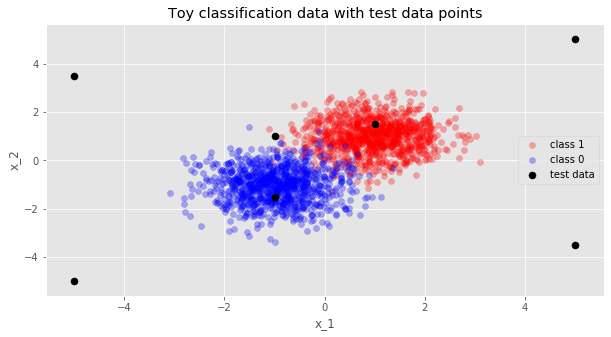

In [4]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('Toy classification data with test data points')
ax.legend(loc='best')
plt.show()

## Initial Neural Network Training

In [5]:
batch_size = 256
num_classes = 2
epochs = 50

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (1600, 2)
x_test shape: (400, 2)


In [7]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
input_shape = x_train.shape[1]
input_shape

2

In [9]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor, training=False)


def get_model(mc=False, p=0.5, act="relu"):
    inp = Input(shape=(input_shape,))
    x = Dense(128, activation=act)(inp)
    x = Dense(64, activation=act)(x)
    x = get_dropout(x, p=p, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [10]:
model = get_model(mc=False, act="relu")


In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 8,770
Trainable params: 8,770
Non-trainable params: 0
_________________________________________________________________


In [12]:
h = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 1s 393us/step - loss: 0.5422 - accuracy: 0.8919 - val_loss: 0.3801 - val_accuracy: 0.9675
Epoch 2/50
1600/1600 [==============================] - 0s 8us/step - loss: 0.3117 - accuracy: 0.9712 - val_loss: 0.2148 - val_accuracy: 0.9750
Epoch 3/50
1600/1600 [==============================] - 0s 10us/step - loss: 0.1817 - accuracy: 0.9725 - val_loss: 0.1376 - val_accuracy: 0.9775
Epoch 4/50
1600/1600 [==============================] - 0s 9us/step - loss: 0.1236 - accuracy: 0.9725 - val_loss: 0.1054 - val_accuracy: 0.9775
Epoch 5/50
1600/1600 [==============================] - 0s 9us/step - loss: 0.0986 - accuracy: 0.9712 - val_loss: 0.0894 - val_accuracy: 0.9800
Epoch 6/50
1600/1600 [==============================] - 0s 9us/step - loss: 0.0865 - accuracy: 0.9712 - val_loss: 0.0810 - val_accuracy: 0.9800
Epoch 7/50
1600/1600 [==============================] - 0s 9us/step - loss: 0.0798 - a

In [13]:
weights = model.get_weights()
model.save_weights('initial_model_weights.h5')

## Deep Ensemble with Bootstrap

In [28]:
ensembles = 30
ens_test_probs = []
ens_ood_probs = []
ens_weights = []

for i in range(ensembles):
    bootstrap_x, bootstrap_y = resample(x,y)
    bootstrap_y = keras.utils.to_categorical(bootstrap_y, num_classes)
    
    # Fit neural network model
    nn = model.fit(bootstrap_x, bootstrap_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                    validation_data=(x_test, y_test))
    
    weights = model.get_weights()
    #Get last Dense layer weights
    ens_weights.append(weights[4].T[1])
    
    # Accuracy of model
    score = model.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    test_prob = model.predict(np.array(x_test))
    
    ens_test_probs.append(test_prob)
    print("Iteration: " + str(i+1) +' Test accuracy:'+ str(np.round(score[1],2)))
        
    #Predictions & uncertainty for test points
    ood_prob = model.predict(np.array(test_points))
    ens_ood_probs.append(ood_prob)


Iteration: 1 Test accuracy:0.98
Iteration: 2 Test accuracy:0.99
Iteration: 3 Test accuracy:0.98
Iteration: 4 Test accuracy:0.99
Iteration: 5 Test accuracy:0.99
Iteration: 6 Test accuracy:0.97
Iteration: 7 Test accuracy:0.97
Iteration: 8 Test accuracy:0.98
Iteration: 9 Test accuracy:0.98
Iteration: 10 Test accuracy:0.98
Iteration: 11 Test accuracy:0.96
Iteration: 12 Test accuracy:0.98
Iteration: 13 Test accuracy:0.98
Iteration: 14 Test accuracy:0.98
Iteration: 15 Test accuracy:0.98
Iteration: 16 Test accuracy:0.99
Iteration: 17 Test accuracy:0.98
Iteration: 18 Test accuracy:0.99
Iteration: 19 Test accuracy:0.99
Iteration: 20 Test accuracy:0.97
Iteration: 21 Test accuracy:0.99
Iteration: 22 Test accuracy:0.99
Iteration: 23 Test accuracy:0.98
Iteration: 24 Test accuracy:0.99
Iteration: 25 Test accuracy:0.99
Iteration: 26 Test accuracy:0.99
Iteration: 27 Test accuracy:0.99
Iteration: 28 Test accuracy:0.99
Iteration: 29 Test accuracy:0.98
Iteration: 30 Test accuracy:0.99


In [15]:
ens_mean = np.mean(np.array(ens_test_probs),axis=0)
pred_test_labels = (ens_mean > 0.5).astype(np.int) 
score = accuracy_score(y_test, pred_test_labels)
print("Ensemble prediction accuracy score for test data: ", score)

Ensemble prediction accuracy score for test data:  0.9775


In [16]:
ens_variance = np.std(np.array(ens_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("Epistemic uncertainty for test point: " + str(test_points[i]) + " : " + str(np.round(ens_variance[i][0],3)))

Epistemic uncertainty for test point: (-5, -5) : 0.0
Epistemic uncertainty for test point: (-5, 3.5) : 0.028
Epistemic uncertainty for test point: (5, 5) : 0.0
Epistemic uncertainty for test point: (5, -3.5) : 0.0
Epistemic uncertainty for test point: (-1, 1) : 0.037
Epistemic uncertainty for test point: (-1, -1.5) : 0.0
Epistemic uncertainty for test point: (1, 1.5) : 0.0


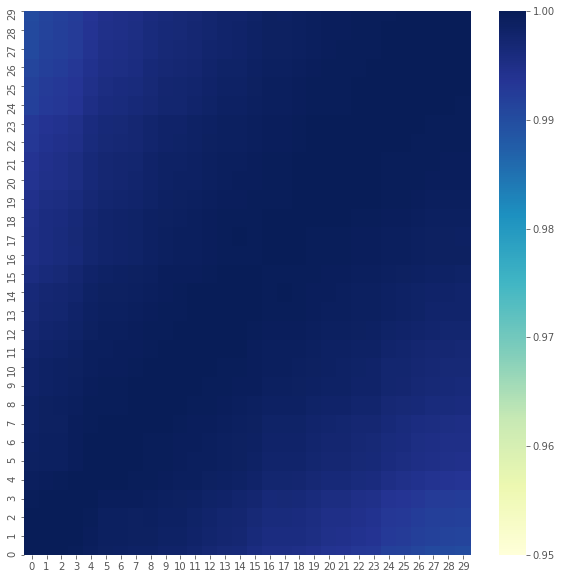

In [54]:
df = pd.DataFrame(np.array(ens_weights).T)

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df.corr(),vmin=0.95, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
ax.invert_yaxis()
plt.show()

In [86]:
from sklearn.manifold import TSNE
labels = np.argmax(ens_mean, axis=-1)   
X_embedded = TSNE(n_components=2).fit_transform(labels.reshape(-1, 1))
X_embedded.shape

(400, 2)

## Bayesian Dropout Subsampling

In [49]:
bayes_iters = 30
dropout_post_predictions = []
dropout_ood_probs = []
drop_weights = []

for i in range(bayes_iters):
    #Generate random p value for Dropout ratio
    p_rand = np.random.random()
    
    drop_model = get_model(mc=True, p= p_rand, act="relu")
    
    #Initialize model with pre-trained weights
    drop_model.load_weights('initial_model_weights.h5')
    h_mc = drop_model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test))
    
    weights = drop_model.get_weights()
    #Get last Dense layer weights
    drop_weights.append(weights[4].T[1])
    
    # Accuracy of model
    score = drop_model.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    print("Iteration: " + str(i+1) + " Random p: " + str(np.round(p_rand,2)) + ' Test accuracy: ', str(np.round(score[1],2)))
    
    #Posterior predictions
    y_pred = drop_model.predict(x_test)
    dropout_post_predictions.append(y_pred)
    
    #Predictions & uncertainty for test points
    ood_prob = drop_model.predict(np.array(test_points))
    dropout_ood_probs.append(ood_prob)


Iteration: 1 Random p: 0.88 Test accuracy:  0.97
Iteration: 2 Random p: 0.47 Test accuracy:  0.98
Iteration: 3 Random p: 0.31 Test accuracy:  0.98
Iteration: 4 Random p: 0.97 Test accuracy:  0.78
Iteration: 5 Random p: 0.76 Test accuracy:  0.98
Iteration: 6 Random p: 0.15 Test accuracy:  0.97
Iteration: 7 Random p: 0.68 Test accuracy:  0.98
Iteration: 8 Random p: 0.27 Test accuracy:  0.98
Iteration: 9 Random p: 0.4 Test accuracy:  0.98
Iteration: 10 Random p: 0.6 Test accuracy:  0.98
Iteration: 11 Random p: 0.4 Test accuracy:  0.98
Iteration: 12 Random p: 0.86 Test accuracy:  0.98
Iteration: 13 Random p: 0.85 Test accuracy:  0.97
Iteration: 14 Random p: 0.8 Test accuracy:  0.97
Iteration: 15 Random p: 0.15 Test accuracy:  0.98
Iteration: 16 Random p: 0.16 Test accuracy:  0.99
Iteration: 17 Random p: 0.38 Test accuracy:  0.98
Iteration: 18 Random p: 0.73 Test accuracy:  0.98
Iteration: 19 Random p: 0.39 Test accuracy:  0.98
Iteration: 20 Random p: 0.93 Test accuracy:  0.93
Iteration: 21

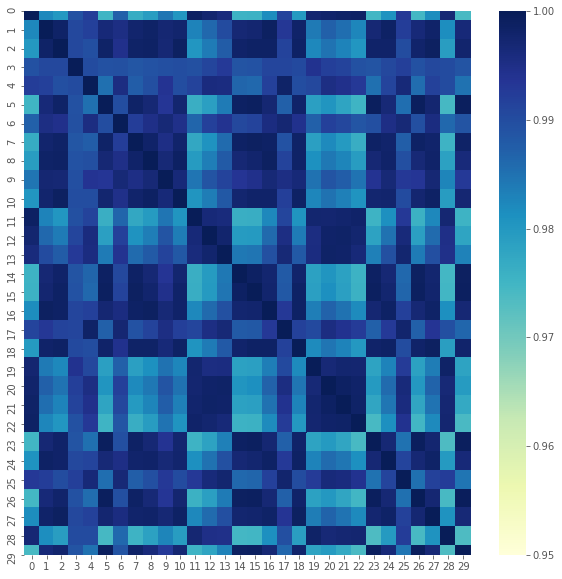

In [53]:
df = pd.DataFrame(np.array(drop_weights).T)

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df.corr(),vmin=0.95, vmax=1, cmap="YlGnBu") 
#ax.invert_yaxis()
plt.show()

In [42]:
dropout_posterior_mean_preds = np.mean(np.array(dropout_post_predictions),axis=0)
dropout_posterior_mean_preds.shape

(400, 2)

In [43]:
dropout_pred_test_labels = (dropout_posterior_mean_preds > 0.5).astype(np.int) 
dropout_acc_score = accuracy_score(y_test, dropout_pred_test_labels)
print("Bayesian Dropout posterior predictive mean accuracy score for test data: ", dropout_acc_score)

Bayesian Dropout posterior predictive mean accuracy score for test data:  0.98


In [44]:
drop_ood_variance = np.std(np.array(dropout_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("Epistemic uncertainty for test point: " + str(test_points[i]) + " : " + str(np.round(drop_ood_variance[i][0],3)))

Epistemic uncertainty for test point: (-5, -5) : 0.009
Epistemic uncertainty for test point: (-5, 3.5) : 0.006
Epistemic uncertainty for test point: (5, 5) : 0.008
Epistemic uncertainty for test point: (5, -3.5) : 0.021
Epistemic uncertainty for test point: (-1, 1) : 0.019
Epistemic uncertainty for test point: (-1, -1.5) : 0.009
Epistemic uncertainty for test point: (1, 1.5) : 0.007
